# Good Faith Newcomer Prediction

Aaron has a labeled dataset of newcomers to English Wikipedia. Newcomers are labeled as good-faith or bad-faith based on Wikipedians' judgements of the newcomers' edits in their first edit session. Aaron used STiki scores to construct a bayesian prediction model of good-faith newcomers. In this notebook, I'll try to reproduce his results using ORES scores as well as try out some other modeling strategies.

In [1]:
% matplotlib inline
import pandas as pd
import urllib
import requests
from scipy.stats import beta
import numpy as np
from sklearn.metrics import roc_auc_score
import datetime
import matplotlib.pyplot as plt 
import pickle
from math import log, factorial, exp
import os

### Download newcomer quality data

In [2]:
DATA_URL = "https://datasets.wikimedia.org/public-datasets/enwiki/rise-and-decline/newbie_quality_sample.tsv"
_ = urllib.request.urlretrieve(DATA_URL, "newbie_quality_sample.tsv")

In [3]:
labels_df = pd.read_csv("newbie_quality_sample.tsv", sep = '\t')
labels_df.index = labels_df.user_id
labels_df["good_faith"] = labels_df.category > 2 

In [4]:
labels_df["good_faith"].value_counts()

True     875
False    188
Name: good_faith, dtype: int64

### Get early newcomer contribution history

In [5]:

def get_user_name(uid):
        url = 'http://en.wikipedia.org/w/api.php?action=query&format=json&list=users&usprop=&ususerids=%d'
        try:
            r = requests.get( url % uid).json()
            return r["query"]['users'][0]['name']
        except:
            print("Error getting username: ", uid)
            return None

def get_user_contribs(uname, uclimit = 100):
    params = {'action': 'query',
           'format': 'json',
           'list' : 'usercontribs',
           'uclimit': uclimit,
           'ucdir': 'newer',
           'ucprop': 'oresscores|ids|timestamp|title',
           'ucuser': uname
          }

    try:
        r = requests.get('http://en.wikipedia.org/w/api.php', params=params).json()
        return r["query"]['usercontribs']
    except:
        print("Error getting contribs: ", uname)
        return []

In [6]:
contributions_pickle = 'newbie_quality_sample_contributions.pkl'

if not os.path.isfile(contributions_pickle): 
    contribs = {}
    
    for i, uid in enumerate(df.user_id):
        if i % 100 ==0:
            print(i)
            
        uname = get_user_name(uid)
        if uname is not None:
            contribs[uid] = get_user_contribs(uname, uclimit = 100)
    
    with open(contributions_pickle, 'wb') as fp:
        pickle.dump(contribs, fp)
else:
    with open(contributions_pickle, 'rb') as fp:
        contribs = pickle.load(fp)

In [7]:
# remove users who have no contributions
# TODO: why are there so many? Did they change their usernames?
labels_df['has_contribs'] = labels_df['user_id'].apply(lambda x: len(contribs[x]) > 0)
print(labels_df['has_contribs'].value_counts())
labels_df = labels_df.query("has_contribs == 1")

True     952
False    111
Name: has_contribs, dtype: int64


### Get newcomer first edit session, main namespace edits, etc

In [8]:
def get_main_ns_contribs(contribs):
    return {k:[x for x in v if x['ns'] == 0] for k,v in contribs.items()}

def parse_dt(s):
    return datetime.datetime.strptime(s, '%Y-%m-%dT%H:%M:%SZ')

def get_first_edit_session(contribs, gap = 60):
    fes_contribs = {}
    
    for k,v in contribs.items():
        if len(v) <= 1:
            fes_contribs[k] = v
        else:
            session = [v[0]]
            t_prev = parse_dt(v[0]['timestamp'])
            for x in v[1:]:
                t_curr = parse_dt(x['timestamp'])
                delta = t_curr - t_prev
                
                if delta > datetime.timedelta(minutes=gap):
                    break
                else:
                    t_prev = t_curr
                    session.append(x)
            fes_contribs[k] = session
    return fes_contribs

def get_first_edit(contribs):
    return {k:v[:2] for k,v in contribs.items()}


In [9]:
# first edit session contrubutions
fes_contribs = get_first_edit_session(contribs)
# main namespace contributions (first 100)
ns0_contribs = get_main_ns_contribs(contribs)
# first edit session main namespace contrubutions
ns0_fes_contribs = get_first_edit_session(ns0_contribs)
# first main namespace edit
ns0_fe_contribs = get_first_edit(ns0_contribs)

# Learning

In [10]:
from sklearn.base import BaseEstimator, ClassifierMixin
import random

# utility for geting "features" and labels for snuggle model
def get_X_y(contribs, labels_df):

    y = labels_df.sample(frac=1)['good_faith']
    X = pd.DataFrame(y)
    X['user_id'] = X.index
    X['contribs'] = X['user_id'].apply(lambda x: contribs[x])
    return X['contribs'], y

class SnuggleScorer(BaseEstimator, ClassifierMixin):

    def __init__(self, ):
        self.EPSILON = 0.005
    
    def fit(self, X, y):
        
        df = pd.DataFrame({"good_faith":y, "contribs":X})
        
        df_0 = df.query('good_faith == 0')
        self.scores_0 = [c['oresscores']['damaging']['true'] for cs in df_0['contribs'] for c in cs]
        
        df_1 = df.query('good_faith == 1')
        self.scores_1 = [c['oresscores']['damaging']['true'] for cs in df_1['contribs'] for c in cs]
        
        self.p_0_prior = float(len(df_0)) / (len(df_0) + len(df_1))
        self.p_1_prior = 1 - self.p_0_prior
        
        self.a0, self.b0, _, _ = beta.fit(self.scores_0)
        self.a1, self.b1, _, _ = beta.fit(self.scores_1)
        self.model_0 = beta(self.a0, self.b0)
        self.model_1 = beta(self.a1, self.b1)
        return self
        
    
    def beta_likelihood(self, scores, model):
        """
        Straight from https://github.com/wikimedia/analytics-snuggle/blob/master/snuggle/desirability.py#L18-L27
        """
        log_p = log(factorial(len(scores)))
        for score in scores:
            log_p += log(
            model.cdf(min(score + self.EPSILON, 1)) - 
            model.cdf(max(score - self.EPSILON, 0.005))
            )

        return exp(log_p)
        

    def predict_proba_single(self, single_contribs):
        """
        Straight from https://github.com/wikimedia/analytics-snuggle/blob/master/snuggle/desirability.py#L30-L34
        """
        scores =[c['oresscores']['damaging']['true'] for c in single_contribs]
        
        p_0 = self.beta_likelihood(scores, self.model_0) * self.p_0_prior
        p_1 = self.beta_likelihood(scores, self.model_1) * self.p_1_prior
        
        return p_1 / (p_1 + p_0)
    
    def predict_proba(self, contribs):
        pred = np.array([self.predict_proba_single(c) for c in contribs])
        return np.vstack([1-pred, pred]).T

    
    def plot_betas(self):
        
        """
        Plot distribution over damaging scores for revisions
        in first edit sessions of good-faith and not good-faith newcomers
        """
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
        ax1.set_title("Good Faith Newbies")
        ax1.hist(self.scores_1, normed = True)
        x = np.linspace(0, 1, 100)
        rv = beta(self.a1, self.b1)
        ax1.plot(x, rv.pdf(x), 'k-', lw=2, label='pdf')
        
        ax2.set_title("Bad Faith Newbies")
        ax2.hist(self.scores_0, normed = True)
        x = np.linspace(0, 1, 100)
        rv = beta(self.a0, self.b0)
        ax2.plot(x, rv.pdf(x), 'k-', lw=2, label='pdf')
        
        ax1.set_xlabel("P(edit is damaging)")
        ax2.set_xlabel("P(edit is damaging)")


In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

print("Score first edit session:")
X, y = get_X_y(ns0_fes_contribs, labels_df)
scores = cross_val_score(SnuggleScorer(), X, y, cv=StratifiedKFold(n_splits=10), scoring = "roc_auc")
print("ROC: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Score first edit session:


/Users/ellerywulczyn/miniconda3/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:407: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*sqrt(a + b + 1) / (a + b + 2) / sqrt(a*b)


ROC: 0.769 (+/- 0.097)


In [12]:
print("Score up to 100 edits:")
X, y = get_X_y(ns0_contribs, labels_df)
scores = cross_val_score(SnuggleScorer(), X, y, cv=StratifiedKFold(n_splits=10), scoring = "roc_auc")
print("ROC: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Score up to 100 edits:


/Users/ellerywulczyn/miniconda3/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:407: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*sqrt(a + b + 1) / (a + b + 2) / sqrt(a*b)


ROC: 0.721 (+/- 0.163)


Observing more user edits does not improve the model?

/Users/ellerywulczyn/miniconda3/lib/python3.5/site-packages/scipy/stats/_continuous_distns.py:407: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*sqrt(a + b + 1) / (a + b + 2) / sqrt(a*b)


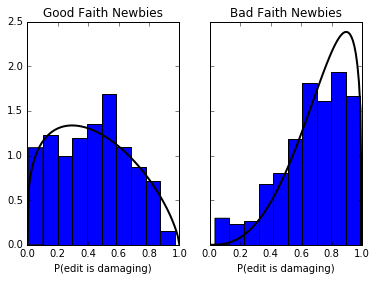

In [13]:
# fit model on all data and check betas
SC = SnuggleScorer()
X, y = get_X_y(ns0_fes_contribs, labels_df)
SC.fit(X, y).plot_betas()

The Snuggle paper reports an ROC of .88. We will need to figure out where the discrepancy comes from:
1. concecptual or implementation error in reproduction
2. difference in accuracy/semantics between ORES and STiki scores
3. small sample size effect in paper (n=150 vs n=1000)

### Random Forest Model

The Snuggle model is essentially a naive bayes classifier. Lets try a different learning algorithm.

In [14]:
from time import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier


In [15]:
def get_features(user_id, contributions, max_edits = 10):
    """
    Return various summary stats of ORES scores for edit in first edit session
    """
    scores = [c['oresscores']['damaging']['true'] for c in contributions[user_id]][:max_edits]
    num_edits = len(scores)
    median_score = np.median(scores or [0])
    max_score = max(scores or [0])
    hist =  np.histogram(scores)[0] / max(1, num_edits)
    cdf = np.cumsum(hist)
    features = np.concatenate([np.array([num_edits, median_score, max_score ]), hist, cdf])
    return pd.Series(features)

In [20]:
# use up to 10 first edits
X = labels_df['user_id'].apply(lambda x: get_features(x, ns0_contribs, max_edits = 10))
# apply snuggle to first edit session
X['snuggle'] = labels_df['user_id'].apply(lambda x: SC.predict_proba_single(ns0_fes_contribs.get(x, [])))
y = labels_df['good_faith']

In [22]:
# build a classifier
clf = RandomForestClassifier()


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  2*results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, 10, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(2, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              "n_estimators": sp_randint(20, 100)}

# run randomized search
n_iter_search = 30
random_search = RandomizedSearchCV(clf,
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search,
                                   scoring = "roc_auc")

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)


RandomizedSearchCV took 8.66 seconds for 30 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.812 (std: 0.079)
Parameters: {'max_depth': 3, 'criterion': 'gini', 'min_samples_split': 8, 'min_samples_leaf': 3, 'bootstrap': True, 'max_features': 5, 'n_estimators': 51}

Model with rank: 2
Mean validation score: 0.810 (std: 0.063)
Parameters: {'max_depth': 3, 'criterion': 'entropy', 'min_samples_split': 7, 'min_samples_leaf': 4, 'bootstrap': False, 'max_features': 7, 'n_estimators': 54}

Model with rank: 3
Mean validation score: 0.808 (std: 0.085)
Parameters: {'max_depth': 3, 'criterion': 'gini', 'min_samples_split': 3, 'min_samples_leaf': 8, 'bootstrap': False, 'max_features': 10, 'n_estimators': 96}

